#Taxi Cancellation Predictive Analysis
by Abigail McDonald

####Business Problem: 
Yourcabs.com, a taxi company in Bangalore, India, was having a problem with drivers canceling calls too close to the scheduled arrival time.  This would potentially leave customers without a timely replacement driver.  Yourcabs had both an online portal and phone-in booking system.  Yourcabs needs to be able to predict which calls will be cancelled.

**Data**:
The dataset contains collected data from 10,000 bookings between the years of 2011 and 2013. Data includes: booking ID, the ID of the customer, vehicle model type, type of package ordered (represents hrs and kilometers), type of travel (1=long distance, 2= point to point, 3= hourly rental), unique id for each area (from/to), unique id of city (from/to), time stamp of trip start and end, mobile/desktop booking, time stamp of booking creation, latitude of from/to area, longitude of from/to area, and whether the booking was cancelled (1) or not (0) due to unavailability of a car.


###Data Wrangling

In [ ]:
#load libraries and dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

!pip install dmba
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import gainsChart, liftChart

taxi_df = pd.read_csv("Taxi-cancellation-case.csv")
taxi_df.head()

no display found. Using non-interactive Agg backend


row#  user_id  vehicle_model_id  package_id  travel_type_id  from_area_id  \
0     1    17712                12         NaN               2        1021.0   
1     2    17037                12         NaN               2         455.0   
2     3      761                12         NaN               2         814.0   
3     4      868                12         NaN               2         297.0   
4     5    21716                28         NaN               2        1237.0   

   to_area_id  from_city_id  to_city_id     from_date      to_date  \
0      1323.0           NaN         NaN  1/1/13 22:33          NaN   
1      1330.0           NaN         NaN  1/1/13 12:43          NaN   
2       393.0           NaN         NaN   1/2/13 0:28  1/3/13 0:00   
3       212.0           NaN         NaN  1/1/13 13:12          NaN   
4       330.0           NaN         NaN  1/1/13 16:33          NaN   

   online_booking  mobile_site_booking booking_created   from_lat  from_long  \
0               0                    0     1/1/13 8:01  13.028530   77.54625   
1               0                    0     1/1/13 9:59  12.999874   77.67812   
2               1                    0    1/1/13 12:14  12.908993   77.68890   
3               0                    0    1/1/13 12:42  12.997890   77.61488   
4               0                    0    1/1/13 15:07  12.926450   77.61206   

      to_lat    to_long  Car_Cancellation  
0  12.869805  77.653211                 0  
1  12.953434  77.706510                 0  
2  13.199560  77.706880                 0  
3  12.994740  77.607970                 0  
4  12.858833  77.589127                 0

In [ ]:
#look at variables and basic df info
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   row#                 10000 non-null  int64  
 1   user_id              10000 non-null  int64  
 2   vehicle_model_id     10000 non-null  int64  
 3   package_id           1752 non-null   float64
 4   travel_type_id       10000 non-null  int64  
 5   from_area_id         9985 non-null   float64
 6   to_area_id           7909 non-null   float64
 7   from_city_id         3706 non-null   float64
 8   to_city_id           339 non-null    float64
 9   from_date            10000 non-null  object 
 10  to_date              5822 non-null   object 
 11  online_booking       10000 non-null  int64  
 12  mobile_site_booking  10000 non-null  int64  
 13  booking_created      10000 non-null  object 
 14  from_lat             9985 non-null   float64
 15  from_long            9985 non-null   

In [ ]:
#find total longitudnal and latitudnal distances traveled
taxi_df['longitude'] = taxi_df['to_long'] - taxi_df['from_long']
taxi_df['latitude'] = taxi_df['to_lat'] - taxi_df['from_lat']

#define a Euclidean function
def euclidean(a, b):
    return (a ** 2 + b ** 2) ** 0.5

#calculate Euclidean distance traveled
taxi_df['distance'] = euclidean(taxi_df['longitude'],taxi_df['latitude'])
taxi_df.head()

row#  user_id  vehicle_model_id  package_id  travel_type_id  from_area_id  \
0     1    17712                12         NaN               2        1021.0   
1     2    17037                12         NaN               2         455.0   
2     3      761                12         NaN               2         814.0   
3     4      868                12         NaN               2         297.0   
4     5    21716                28         NaN               2        1237.0   

   to_area_id  from_city_id  to_city_id     from_date  ...  \
0      1323.0           NaN         NaN  1/1/13 22:33  ...   
1      1330.0           NaN         NaN  1/1/13 12:43  ...   
2       393.0           NaN         NaN   1/2/13 0:28  ...   
3       212.0           NaN         NaN  1/1/13 13:12  ...   
4       330.0           NaN         NaN  1/1/13 16:33  ...   

  mobile_site_booking  booking_created   from_lat from_long     to_lat  \
0                   0      1/1/13 8:01  13.028530  77.54625  12.869805   
1                   0      1/1/13 9:59  12.999874  77.67812  12.953434   
2                   0     1/1/13 12:14  12.908993  77.68890  13.199560   
3                   0     1/1/13 12:42  12.997890  77.61488  12.994740   
4                   0     1/1/13 15:07  12.926450  77.61206  12.858833   

     to_long  Car_Cancellation  longitude  latitude  distance  
0  77.653211                 0   0.106961 -0.158725  0.191401  
1  77.706510                 0   0.028390 -0.046440  0.054430  
2  77.706880                 0   0.017980  0.290567  0.291123  
3  77.607970                 0  -0.006910 -0.003150  0.007594  
4  77.589127                 0  -0.022933 -0.067617  0.071400  

[5 rows x 22 columns]

In [ ]:
#drop unnecessary columns
taxi_df = taxi_df.drop(['row#', 'user_id', 'from_city_id', 'to_city_id', 'to_date', 
                        'from_lat', 'from_long', 'to_lat', 'to_long','longitude','latitude'], axis = 1)
taxi_df.head()

vehicle_model_id  package_id  travel_type_id  from_area_id  to_area_id  \
0                12         NaN               2        1021.0      1323.0   
1                12         NaN               2         455.0      1330.0   
2                12         NaN               2         814.0       393.0   
3                12         NaN               2         297.0       212.0   
4                28         NaN               2        1237.0       330.0   

      from_date  online_booking  mobile_site_booking booking_created  \
0  1/1/13 22:33               0                    0     1/1/13 8:01   
1  1/1/13 12:43               0                    0     1/1/13 9:59   
2   1/2/13 0:28               1                    0    1/1/13 12:14   
3  1/1/13 13:12               0                    0    1/1/13 12:42   
4  1/1/13 16:33               0                    0    1/1/13 15:07   

   Car_Cancellation  distance  
0                 0  0.191401  
1                 0  0.054430  
2                 0  0.291123  
3                 0  0.007594  
4                 0  0.071400

In [ ]:
#view data types and change if necessary
taxi_df.dtypes

vehicle_model_id         int64
package_id             float64
travel_type_id           int64
from_area_id           float64
to_area_id             float64
from_date               object
online_booking           int64
mobile_site_booking      int64
booking_created         object
Car_Cancellation         int64
distance               float64
dtype: object

In [ ]:
#find and deal with missing values
taxi_df.isna().sum()

vehicle_model_id          0
package_id             8248
travel_type_id            0
from_area_id             15
to_area_id             2091
from_date                 0
online_booking            0
mobile_site_booking       0
booking_created           0
Car_Cancellation          0
distance               2091
dtype: int64

In [ ]:
#missing values are categorical, add new category 0 = not point to point or part of a package
taxi_df = taxi_df.fillna(0)
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vehicle_model_id     10000 non-null  int64  
 1   package_id           10000 non-null  float64
 2   travel_type_id       10000 non-null  int64  
 3   from_area_id         10000 non-null  float64
 4   to_area_id           10000 non-null  float64
 5   from_date            10000 non-null  object 
 6   online_booking       10000 non-null  int64  
 7   mobile_site_booking  10000 non-null  int64  
 8   booking_created      10000 non-null  object 
 9   Car_Cancellation     10000 non-null  int64  
 10  distance             10000 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 859.5+ KB


In [ ]:
#change dtypes for id columns
taxi_df.vehicle_model_id = taxi_df.vehicle_model_id.astype('category')
taxi_df.package_id = taxi_df.package_id.astype('category')
taxi_df.travel_type_id = taxi_df.travel_type_id.astype('category')
taxi_df.from_area_id = taxi_df.from_area_id.astype('category')
taxi_df.to_area_id = taxi_df.to_area_id.astype('category')

#convert dates to datetime objects
taxi_df.from_date = taxi_df.from_date.astype('datetime64')
taxi_df.booking_created = taxi_df.booking_created.astype('datetime64')

taxi_df.dtypes

vehicle_model_id             category
package_id                   category
travel_type_id               category
from_area_id                 category
to_area_id                   category
from_date              datetime64[ns]
online_booking                  int64
mobile_site_booking             int64
booking_created        datetime64[ns]
Car_Cancellation                int64
distance                      float64
dtype: object

In [ ]:
#separate month,day,hour into separate columns for from date and drop original columns
taxi_df['from_month'] = pd.to_datetime(taxi_df['from_date']).dt.month
taxi_df['from_day'] = pd.to_datetime(taxi_df['from_date']).dt.day
taxi_df['from_hour'] = pd.to_datetime(taxi_df['from_date']).dt.hour

#do the same for booking_created
taxi_df['booking_month'] = pd.to_datetime(taxi_df['booking_created']).dt.month
taxi_df['booking_day'] = pd.to_datetime(taxi_df['booking_created']).dt.day
taxi_df['booking_hour'] = pd.to_datetime(taxi_df['booking_created']).dt.hour

#drop original columns
taxi_df = taxi_df.drop(['from_date', 'booking_created'], axis = 1)
taxi_df.head()

vehicle_model_id package_id travel_type_id from_area_id to_area_id  \
0               12        0.0              2       1021.0     1323.0   
1               12        0.0              2        455.0     1330.0   
2               12        0.0              2        814.0      393.0   
3               12        0.0              2        297.0      212.0   
4               28        0.0              2       1237.0      330.0   

   online_booking  mobile_site_booking  Car_Cancellation  distance  \
0               0                    0                 0  0.191401   
1               0                    0                 0  0.054430   
2               1                    0                 0  0.291123   
3               0                    0                 0  0.007594   
4               0                    0                 0  0.071400   

   from_month  from_day  from_hour  booking_month  booking_day  booking_hour  
0           1         1         22              1            1             8  
1           1         1         12              1            1             9  
2           1         2          0              1            1            12  
3           1         1         13              1            1            12  
4           1         1         16              1            1            15

###Exploratory Data Analysis

In [ ]:
taxi_df.describe(include='all')

vehicle_model_id  package_id  travel_type_id  from_area_id  \
count            10000.0     10000.0         10000.0       10000.0   
unique              20.0         8.0             3.0         523.0   
top                 12.0         0.0             2.0         393.0   
freq              7279.0      8248.0          7909.0         897.0   
mean                 NaN         NaN             NaN           NaN   
std                  NaN         NaN             NaN           NaN   
min                  NaN         NaN             NaN           NaN   
25%                  NaN         NaN             NaN           NaN   
50%                  NaN         NaN             NaN           NaN   
75%                  NaN         NaN             NaN           NaN   
max                  NaN         NaN             NaN           NaN   

        to_area_id  online_booking  mobile_site_booking  Car_Cancellation  \
count      10000.0    10000.000000          10000.00000      10000.000000   
unique       480.0             NaN                  NaN               NaN   
top            0.0             NaN                  NaN               NaN   
freq        2091.0             NaN                  NaN               NaN   
mean           NaN        0.353300              0.04240          0.074300   
std            NaN        0.478019              0.20151          0.262272   
min            NaN        0.000000              0.00000          0.000000   
25%            NaN        0.000000              0.00000          0.000000   
50%            NaN        0.000000              0.00000          0.000000   
75%            NaN        1.000000              0.00000          0.000000   
max            NaN        1.000000              1.00000          1.000000   

            distance    from_month      from_day     from_hour  booking_month  \
count   10000.000000  10000.000000  10000.000000  10000.000000   10000.000000   
unique           NaN           NaN           NaN           NaN            NaN   
top              NaN           NaN           NaN           NaN            NaN   
freq             NaN           NaN           NaN           NaN            NaN   
mean        0.123639      6.435100     15.696700     11.953700       6.378400   
std         0.105274      2.955683      8.765671      6.092624       2.929551   
min         0.000000      1.000000      1.000000      0.000000       1.000000   
25%         0.032486      4.000000      8.000000      7.000000       4.000000   
50%         0.099735      7.000000     15.000000     11.000000       7.000000   
75%         0.215028      9.000000     23.000000     17.000000       9.000000   
max         0.480033     12.000000     31.000000     23.000000      11.000000   

         booking_day  booking_hour  
count   10000.000000  10000.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
mean       15.837000     14.396900  
std         8.962235      5.390703  
min         1.000000      0.000000  
25%         8.000000     11.000000  
50%        16.000000     15.000000  
75%        24.000000     19.000000  
max        31.000000     23.000000

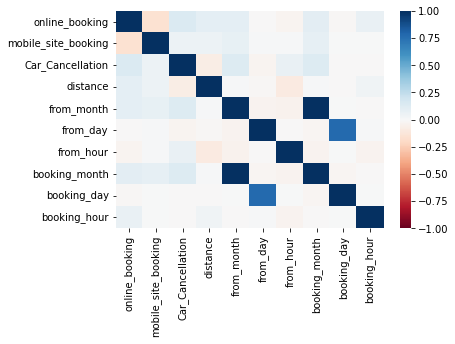

In [ ]:
#correlation between variables
taxi_df.corr()
corr = taxi_df.corr()
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, 
            cmap="RdBu")

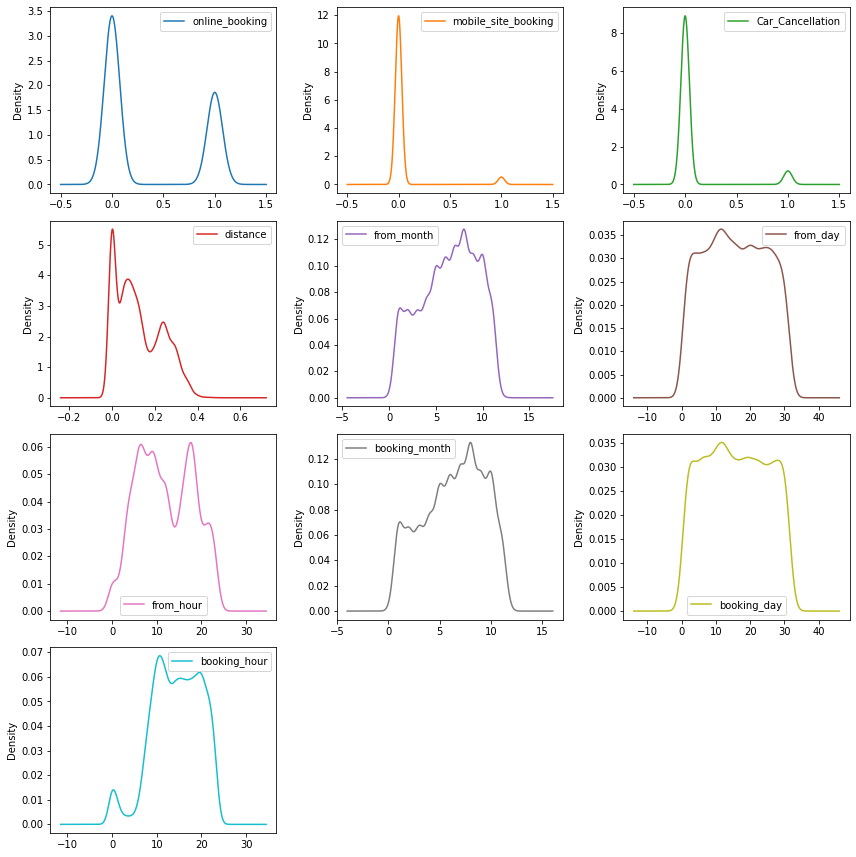

In [ ]:
taxi_df.plot(kind='density', subplots=True, layout=(-1, 3), figsize=(12,12), sharex=False);
plt.tight_layout()

###Predictive Modeling

In [ ]:
# split data into train/test 
X = taxi_df.drop(columns='Car_Cancellation')
y = taxi_df['Car_Cancellation']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (6000, 14) Validation set: (4000, 14)


base model: Classification Tree

others:
*   KNN
*   Naive Bayes
*   Random Forest
*   LDA


In [ ]:
# run a classification tree
deepClassTree = DecisionTreeClassifier(random_state=1)
deepClassTree.fit(train_X, train_y)

classNames = [str(s) for s in deepClassTree.classes_]

print("Classes: {}".format(', '.join(classNames)))
print('Tree has {} nodes'.format(deepClassTree.tree_.node_count))
plotDecisionTree(deepClassTree, feature_names=train_X.columns, 
                 class_names=classNames, impurity=False)

Classes: 0, 1
Tree has 995 nodes


In [ ]:
importance = pd.DataFrame({'features': train_X.columns, 
                           'importance': deepClassTree.feature_importances_})
importance.sort_values(by='importance', ascending=False)

features  importance
7              distance    0.151707
4            to_area_id    0.139064
3          from_area_id    0.135733
10            from_hour    0.103573
9              from_day    0.100060
13         booking_hour    0.089086
12          booking_day    0.081191
11        booking_month    0.074728
8            from_month    0.049685
0      vehicle_model_id    0.029609
5        online_booking    0.023774
6   mobile_site_booking    0.011647
1            package_id    0.008533
2        travel_type_id    0.001610

In [ ]:
# evaluate classification tree
classificationSummary(train_y, deepClassTree.predict(train_X))
print('')
classificationSummary(valid_y, deepClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9998)

       Prediction
Actual    0    1
     0 5552    0
     1    1  447

Confusion Matrix (Accuracy 0.8912)

       Prediction
Actual    0    1
     0 3496  209
     1  226   69


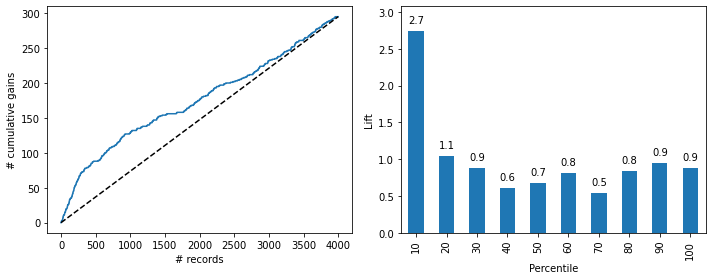

In [ ]:
#gains and decile lift chart
CT_pred = deepClassTree.predict(valid_X)
CT_proba = deepClassTree.predict_proba(valid_X)
CT_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in CT_proba],
                             'p(1)': [p[1] for p in CT_proba],
                             'predicted': CT_pred })

df_CT = CT_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df_CT.actual, ax=axes[0])
liftChart(df_CT.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

In [ ]:
# run Random Forest
rfModel = RandomForestClassifier(random_state=1, n_estimators=100)
rfModel.fit(train_X, train_y)

RandomForestClassifier(random_state=1)

In [ ]:
# evaluate Random Forest
classificationSummary(train_y, rfModel.predict(train_X))
print('')
classificationSummary(valid_y, rfModel.predict(valid_X))

Confusion Matrix (Accuracy 0.9998)

       Prediction
Actual    0    1
     0 5552    0
     1    1  447

Confusion Matrix (Accuracy 0.9297)

       Prediction
Actual    0    1
     0 3686   19
     1  262   33


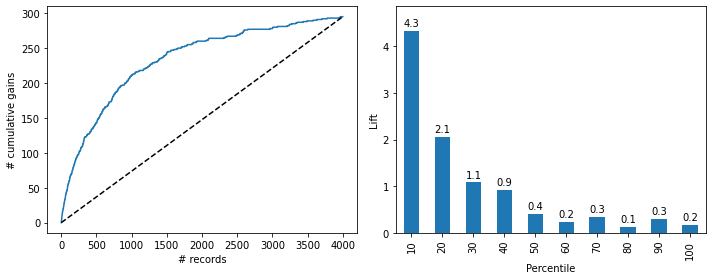

In [ ]:
#gains and decile lift chart
rfModel_pred = rfModel.predict(valid_X)
rfModel_proba = rfModel.predict_proba(valid_X)
rfModel_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in rfModel_proba],
                             'p(1)': [p[1] for p in rfModel_proba],
                             'predicted': rfModel_pred })

df_rfModel = rfModel_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df_rfModel.actual, ax=axes[0])
liftChart(df_rfModel.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

In [ ]:
#run linear discriminant analysis
lda_reg = LinearDiscriminantAnalysis()
lda_reg.fit(train_X, train_y)

LinearDiscriminantAnalysis()

In [ ]:
#evaluate LDA
classificationSummary(train_y,lda_reg.predict(train_X))
print('')
classificationSummary(valid_y, lda_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9252)

       Prediction
Actual    0    1
     0 5548    4
     1  445    3

Confusion Matrix (Accuracy 0.9263)

       Prediction
Actual    0    1
     0 3703    2
     1  293    2


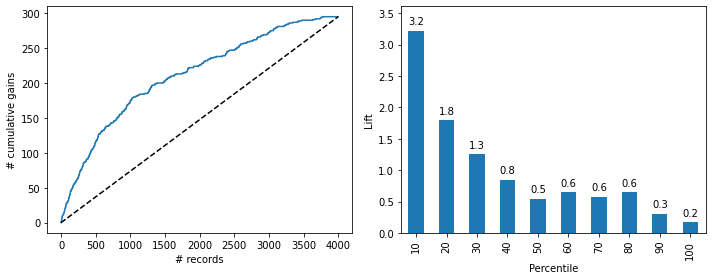

In [ ]:
#gains and decile lift chart
lda_reg_pred = lda_reg.predict(valid_X)
lda_reg_proba = lda_reg.predict_proba(valid_X)
lda_reg_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in lda_reg_proba],
                             'p(1)': [p[1] for p in lda_reg_proba],
                             'predicted': lda_reg_pred })

lda_regModel = lda_reg_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(lda_regModel.actual, ax=axes[0])
liftChart(lda_regModel.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

####Drop/Change categorical data to make it useful for KNN and Naive Bayes

In [ ]:
#drop categorical columns except for travel_type_id
taxi_2 = taxi_df.drop(['vehicle_model_id', 'from_area_id', 'to_area_id'], axis = 1)
taxi_2.head()

package_id travel_type_id  online_booking  mobile_site_booking  \
0        0.0              2               0                    0   
1        0.0              2               0                    0   
2        0.0              2               1                    0   
3        0.0              2               0                    0   
4        0.0              2               0                    0   

   Car_Cancellation  distance  from_month  from_day  from_hour  booking_month  \
0                 0  0.191401           1         1         22              1   
1                 0  0.054430           1         1         12              1   
2                 0  0.291123           1         2          0              1   
3                 0  0.007594           1         1         13              1   
4                 0  0.071400           1         1         16              1   

   booking_day  booking_hour  
0            1             8  
1            1             9  
2            1            12  
3            1            12  
4            1            15

In [ ]:
#create dummies for travel_type_id and package_id
taxi_2 = pd.get_dummies(taxi_2, prefix_sep='_')
taxi_2.head()

online_booking  mobile_site_booking  Car_Cancellation  distance  \
0               0                    0                 0  0.191401   
1               0                    0                 0  0.054430   
2               1                    0                 0  0.291123   
3               0                    0                 0  0.007594   
4               0                    0                 0  0.071400   

   from_month  from_day  from_hour  booking_month  booking_day  booking_hour  \
0           1         1         22              1            1             8   
1           1         1         12              1            1             9   
2           1         2          0              1            1            12   
3           1         1         13              1            1            12   
4           1         1         16              1            1            15   

   ...  package_id_1.0  package_id_2.0  package_id_3.0  package_id_4.0  \
0  ...               0               0               0               0   
1  ...               0               0               0               0   
2  ...               0               0               0               0   
3  ...               0               0               0               0   
4  ...               0               0               0               0   

   package_id_5.0  package_id_6.0  package_id_7.0  travel_type_id_1  \
0               0               0               0                 0   
1               0               0               0                 0   
2               0               0               0                 0   
3               0               0               0                 0   
4               0               0               0                 0   

   travel_type_id_2  travel_type_id_3  
0                 1                 0  
1                 1                 0  
2                 1                 0  
3                 1                 0  
4                 1                 0  

[5 rows x 21 columns]

In [ ]:
# run Naive Bayes
nb = MultinomialNB(alpha=0.01)
nb.fit(train_X, train_y)

MultinomialNB(alpha=0.01)

In [ ]:
# evaluate Naive Bayes
classificationSummary(train_y, nb.predict(train_X))
print('')
classificationSummary(valid_y, nb.predict(valid_X))

Confusion Matrix (Accuracy 0.5822)

       Prediction
Actual    0    1
     0 3239 2313
     1  194  254

Confusion Matrix (Accuracy 0.5815)

       Prediction
Actual    0    1
     0 2190 1515
     1  159  136


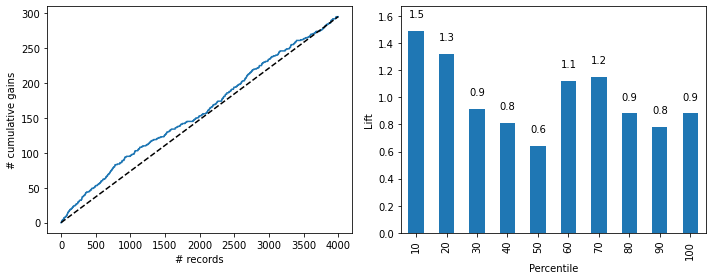

In [ ]:
#gains and decile lift chart
nb_pred = nb.predict(valid_X)
nb_proba = nb.predict_proba(valid_X)
nb_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in nb_proba],
                             'p(1)': [p[1] for p in nb_proba],
                             'predicted': nb_pred })

df_nb = nb_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df_nb.actual, ax=axes[0])
liftChart(df_nb.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

In [ ]:
#KNN

# change column data types to float for StandardScaler
intColumns = [c for c in taxi_2.columns if taxi_2[c].dtype == 'int64']
intColumns.remove('Car_Cancellation')
taxi_2[intColumns] = taxi_2[intColumns].astype('float64')

#repartition
X = list(taxi_2.drop(columns='Car_Cancellation'))
y = 'Car_Cancellation'
train_df, valid_df = train_test_split(taxi_2, test_size=0.4, random_state=1)

#scale variables
scaler = preprocessing.StandardScaler()
scaler.fit(train_df[X])

# Transform the predictors of trainData, validData, and newHousehold
train_X = scaler.transform(train_df[X])
train_y = train_df[y]
valid_X = scaler.transform(valid_df[X])
valid_y = valid_df[y]

In [ ]:
# Train a classifier for different values of k
results = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
results

k  accuracy
0   1   0.88925
1   3   0.91525
2   5   0.92025
3   7   0.92675
4   9   0.92800
5  11   0.92850
6  13   0.92825
7  15   0.92700
8  17   0.92650
9  19   0.92700

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
#evaluate KNN
classificationSummary(train_y, knn.predict(train_X))
print('')
classificationSummary(valid_y, knn.predict(valid_X))

Confusion Matrix (Accuracy 0.9317)

       Prediction
Actual    0    1
     0 5519   33
     1  377   71

Confusion Matrix (Accuracy 0.9285)

       Prediction
Actual    0    1
     0 3677   28
     1  258   37


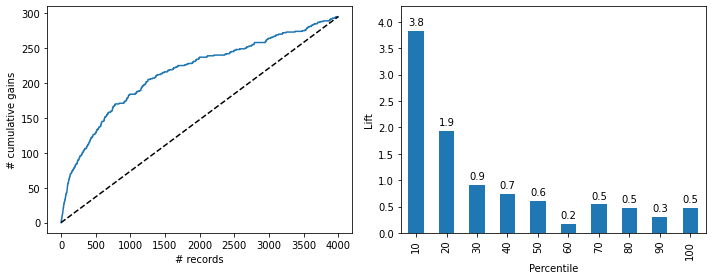

In [ ]:
#gains and decile lift chart
knn_pred = knn.predict(valid_X)
knn_proba = knn.predict_proba(valid_X)
knn_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in knn_proba],
                             'p(1)': [p[1] for p in knn_proba],
                             'predicted': knn_pred })

df_knn = knn_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df_knn.actual, ax=axes[0])
liftChart(df_knn.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()